# Quick Start with Spockflow
Welcome to the Quick Start guide for Spockflow! This guide will walk you through setting up and running your first data enrichment pipeline using Spockflow, designed to be straightforward and user-friendly, especially within a Jupyter notebook environment. Whether you’re a data scientist looking to deploy models quickly or a developer interested in streamlining data workflows, Spockflow offers powerful tools to enrich your data with actionable insights. Let’s get started!

### Preface

This guide assumes that you already have hamilton installed and have installed the GraphViz package for visualization. If not please follow the [Installation Guide](install.md) before continuing.

## Building a Tree
To begin, we import the necessary packages. This guide focuses on exploring the Decision Tree component, a fundamental part of Spockflow.

In [1]:
from spockflow.components.tree import Tree, Action

The `Tree` class allows us to construct decision trees, while the `Action` class serves as a convenient wrapper for standardizing outputs.

To enforce a schema for actions, we define a specific action type:

In [2]:
from typing_extensions import TypedDict
import pandas as pd

class Reject(TypedDict):
    code: int
    description: str

RejectAction = Action[Reject]

Next, we create an instance of the `Tree`:

In [3]:
tree = Tree()

Conditions can be added to the tree using decorators. Here's an example:

In [4]:
@tree.condition(output=RejectAction(code=102, description="My first condition"))
def first_condition(d: pd.Series, e: pd.Series, f: pd.Series) -> pd.Series:
    return (d > 5) & (e > 5) & (f > 5)

This condition triggers a rejection with code 102 when certain criteria are met.
Nested conditions can also be defined. Here's how to nest under a parent condition:

In [5]:
@tree.condition()
def condition_a(a: pd.Series) -> pd.Series:
    return a > 5

@condition_a.condition(output=RejectAction(code=100, description="a and b is out of range"))
def condition_b(b: pd.Series) -> pd.Series:
    return b > 5

@condition_a.condition(output=RejectAction(code=101, description="a and c is out of range"))
def condition_c(c: pd.Series) -> pd.Series:
    return c > 5

Notice that when specifying a child node we make use of `@condition_a.condition` to specify conditions nested under `condition_a`. Furthermore, The base condition has no output set.

It is important to be aware that tree construction is order dependant and rules placed first will be evaluated before rules coming after.

Finally it is generally desired to set a default value if no condition is matched. This can be done as:

*Note: The default behavior is to set all values to pd.NA when nothing is matched.*

In [6]:
tree.set_default(output=RejectAction(code=-1, description="N/A"))

It is also possible to set defaults on child elements with the following code:
```python
condition_a.set_default(output=RejectAction(code=-1, description="N/A"))
```
We now define some dummy data to test the decision tree with as follows:

In [7]:
test_data = pd.DataFrame({
    "num": [1,2,3,4,5,6,7,8], # Note this is for use later in the tutorial
    "a": [5,6,7,8,1,2,3,4],
    "b": [1,0,0,0,2,0,0,0],
    "c": [0,10,0,0,0,10,0,0],
    "d": [0,0,10,0,0,0,0,0],
    "e": [0,0,10,0,0,0,0,0],
    "f": [0,0,10,0,0,0,0,0],
})
test_data

,num,a,b,c,d,e,f
0,1,5,1,0,0,0,0
1,2,6,0,10,0,0,0
2,3,7,0,0,10,10,10
3,4,8,0,0,0,0,0
4,5,1,2,0,0,0,0
5,6,2,0,10,0,0,0
6,7,3,0,0,0,0,0
7,8,4,0,0,0,0,0


Finally we can execute the tree as shown below

In [8]:
tree.execute(test_data)

,code,description
0,-1,N/A
1,101,a and c is out of range
2,102,My first condition
3,-1,N/A
4,-1,N/A
5,-1,N/A
6,-1,N/A
7,-1,N/A


## Execution as part of Hamilton
We have successfully created our first Decision Tree using SpockFlow. Now we would like to combine it as part of a hamilton pipeline. Hamilton allows us to convert a sequence of python functions into an executable Directed Acyclic Graph (DAG). This allows us to trace the flow of data through a sequence of steps. For a detailed explination of Hamilton please refer to the [Hamilton docs](https://hamilton.dagworks.io/en/latest/get-started/your-first-dataflow/). 
Hamilton harnesses the power of functions contained in modules to construct pipelines. The following lines enable us to create Python modules directly within our notebook, empowering us to build Hamilton pipelines seamlessly without the need for external python modules. It is possible to define the above decision tree in a hamilton pipeline as shown below:

In [9]:
%load_ext hamilton.plugins.jupyter_magic

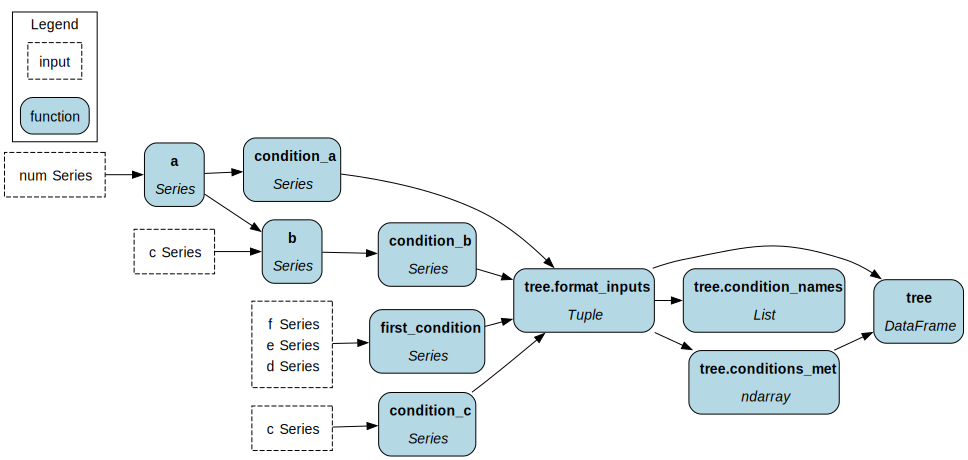

In [10]:
%%cell_to_module --display -m demo_tree
from typing import TypedDict
import pandas as pd

from spockflow.components.tree import Tree, Action
from spockflow.core import initialize_spock_module

class Reject(TypedDict):
    code: int
    description: str

RejectAction = Action[Reject]
tree = Tree()

def a(num: pd.Series) -> pd.Series:
    """ We can add a function to calculate a from an external input """
    return num * 2


def b(a: pd.Series, c: pd.Series) -> pd.Series:
    """It is possible to take in more than one input as well for the transforms"""
    return a+c

@tree.condition()
def condition_a(a: pd.Series) -> pd.Series:
    return a>5

@condition_a.condition(output=RejectAction(code=100, description="a and b is out of range"))
def condition_b(b: pd.Series) -> pd.Series:
    return b>5

@condition_a.condition(output=RejectAction(code=101, description="a and c is out of range"))
def condition_c(c: pd.Series) -> pd.Series:
    return c>5

@tree.condition(output=RejectAction(code=102, description="My first condition"))
def first_condition(d: pd.Series, e: pd.Series, f: pd.Series) -> pd.Series:
    return (d>5)&(e>5)&(f>5)

tree.set_default(output=RejectAction(code=-1, description="N/A"))

initialize_spock_module(__name__, output_names=["tree"])

The above code created a DAG from the decision tree. Note that additional pre-processing steps were inserted for the input values `a` and `b`. We also introduced a new line of code
```python
initialize_spock_module(__name__, output_names=["tree"])
```
This hooks into the hamilton DAG creation system to construct the SpockFlow specific nodes. This is required as by default hamilton only creates nodes for functions in a module. This line also gives us the ability to specify default outputs as is discussed further in this tutorial.

It is now possible to execute this DAG as follows:

In [11]:
from spockflow.core import Driver
dr = Driver({}, demo_tree)
df = dr.execute(inputs=test_data)
df

,code,description
0,-1,N/A
1,-1,N/A
2,100,a and b is out of range
3,100,a and b is out of range
4,100,a and b is out of range
5,100,a and b is out of range
6,100,a and b is out of range
7,100,a and b is out of range


It can be seen in the above code that `spockflow.core.Driver` is used. This is a convinience wrapper to `hamilton.driver.Driver`. However, the SpockFlow driver has context of the default outputs set in the `initialize_spock_module` function. To execute this using the default driver the following code is needed:

In [12]:
from hamilton.driver import Driver as HamiltonDriver
dr_ham = HamiltonDriver({}, demo_tree)
df = dr_ham.execute(inputs=test_data, final_vars=["tree"])
df

,code,description
0,-1,N/A
1,-1,N/A
2,100,a and b is out of range
3,100,a and b is out of range
4,100,a and b is out of range
5,100,a and b is out of range
6,100,a and b is out of range
7,100,a and b is out of range


Here is where Hamilton's true power begins to shine as it is possible to extract outputs from any stage in the execution and furthermore it is possible to override inputs to the different stages of the pipeline.

In [13]:
test_data

,num,a,b,c,d,e,f
0,1,5,1,0,0,0,0
1,2,6,0,10,0,0,0
2,3,7,0,0,10,10,10
3,4,8,0,0,0,0,0
4,5,1,2,0,0,0,0
5,6,2,0,10,0,0,0
6,7,3,0,0,0,0,0
7,8,4,0,0,0,0,0


In [14]:
df = dr.execute(inputs=test_data, final_vars=["condition_b","tree"], overrides={"b": test_data["b"]})
df

,condition_b,tree.code,tree.description
0,False,-1,N/A
1,False,-1,N/A
2,False,102,My first condition
3,False,-1,N/A
4,False,-1,N/A
5,False,101,a and c is out of range
6,False,-1,N/A
7,False,-1,N/A


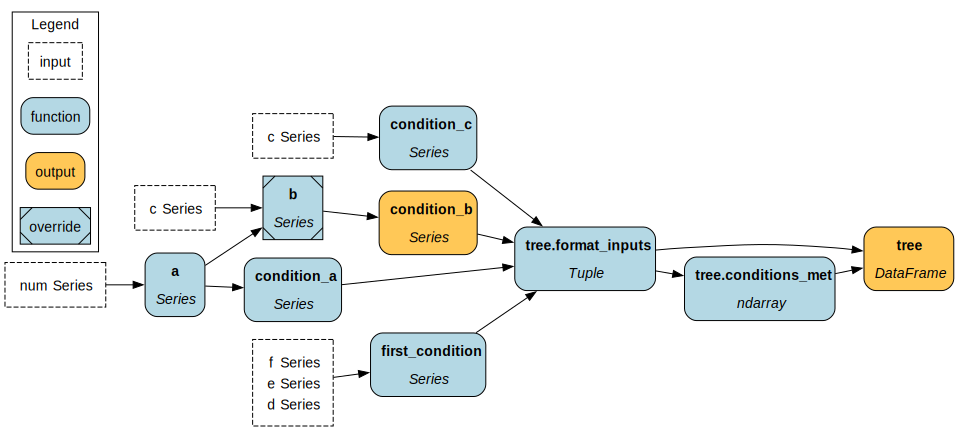

In [15]:
dr.visualize_execution(inputs=test_data, final_vars=["condition_b","tree"], overrides={"b": test_data["b"]})

# Running your flows as a server
*NOTE: This section requires that you have installed SpockFlow with the `[webapp]` dependencies*

Now that we have created a DAG it is possible to package the execution pipeline for execution. For this it is possible to adjust the jupyter magic command above to the `%%writefile` magic as shown below. We will write the contents to main.py under source_dir as this is the default entrypoint for the server.

In [16]:
%%writefile source_dir/main.py
from typing import TypedDict
import pandas as pd

from spockflow.components.tree import Tree, Action
from spockflow.core import initialize_spock_module

class Reject(TypedDict):
    code: int
    description: str

RejectAction = Action[Reject]
tree = Tree()

def a(num: pd.Series) -> pd.Series:
    """ We can add a function to calculate a from an external input """
    return num * 2


def b(a: pd.Series, c: pd.Series) -> pd.Series:
    """It is possible to take in more than one input as well for the transforms"""
    return a+c

@tree.condition()
def condition_a(a: pd.Series) -> pd.Series:
    return a>5

@condition_a.condition(output=RejectAction(code=100, description="a and b is out of range"))
def condition_b(b: pd.Series) -> pd.Series:
    return b>5

@condition_a.condition(output=RejectAction(code=101, description="a and c is out of range"))
def condition_c(c: pd.Series) -> pd.Series:
    return c>5

@tree.condition(output=RejectAction(code=102, description="My first condition"))
def first_condition(d: pd.Series, e: pd.Series, f: pd.Series) -> pd.Series:
    return (d>5)&(e>5)&(f>5)

tree.set_default(output=RejectAction(code=-1, description="N/A"))

initialize_spock_module(__name__, output_names=["tree"])

Overwriting source_dir/main.py


We will also create a inference.py file which allows us to override various aspects of our requests layer including how the data is processed before entering into the model. This is discussed in depth in the [API Customization](../concepts/inference.md) section. For now we are simply converting the json data-structures to a Pandas DataFrame before executing the model.

In [17]:
%%writefile source_dir/inference.py
import typing
import pandas as pd

def pre_process_fn(input_data: typing.Any) -> pd.DataFrame:
    return pd.json_normalize(input_data)


Overwriting source_dir/inference.py


Once executed, your code should be written to the file `source_dir/main.py`. We can now simply start a server as follows:

In [18]:
import os
import json
import requests
os.environ["MODEL_PREFIX"] = os.path.abspath(".")
os.environ["MODEL_RELATIVE_PATH"] = "source_dir"

In [19]:
%%script bash --bg --out OUTPUT_STREAM
uvicorn spockflow.inference.server.asgi:app --reload

In [20]:
resp = requests.post("http://localhost:8000/invocations", json=test_data.to_dict(orient='records'))
pd.DataFrame(resp.json()['tree'])

,code,description
0,-1,N/A
1,-1,N/A
2,100,a and b is out of range
3,100,a and b is out of range
4,100,a and b is out of range
5,100,a and b is out of range
6,100,a and b is out of range
7,100,a and b is out of range


In [21]:
%killbgscripts

All background processes were killed.


## Advanced Deployment
### Docker Deployment
SpockFlow is also deployable as a docker container. The following command can be used to deploy a SpockFlow pipeline in a docker image:

```bash
docker run -v $(pwd)/source_dir:/opt/ml/model --network="host" --entrypoint uvicorn -p 8000:8000 405458085848.dkr.ecr.af-south-1.amazonaws.com/sagemaker-rules-engine:0.1.8 spockflow.inference.server.asgi:app --reload
```
### Debugging in VSCode
Spockflow makes use of a [Starlette](https://www.starlette.io/) app under the hood. It is therefore possible to launch a debug server directly in vscode with the following configuration:
```json
{
    "version": "0.2.0",
    "configurations": [
        {
            "name": "Python Debugger: FastAPI",
            "type": "debugpy",
            "request": "launch",
            "module": "uvicorn",
            "args": [
                "spockflow.inference.server.asgi:app",
                "--reload"
            ],
            "jinja": true,
            "env": {
                // Note the below config may need to change to suite your needs.
                "MODEL_PREFIX": "docs/getting_started",
                "MODEL_RELATIVE_PATH": "source_dir"
            }
        }
    ]
}
```